The first thing we'll do is create a mapping of sequence IDs to their gene ontology (GO) terms stratified by their cooresponding subgraph of the gene ontology (sometimes referred to as "aspects").

In [ ]:
from itertools import islice

import pandas as pd

from collections import defaultdict, Counter

terms_path = "./dataset/train/train_terms.tsv"

bp_seq_to_terms = defaultdict(list)
cc_seq_to_terms = defaultdict(list)
mf_seq_to_terms = defaultdict(list)
all_seq_to_terms = defaultdict(list)

bp_counter = Counter()
cc_counter = Counter()
mf_counter = Counter()
all_counter = Counter()

df = pd.read_csv(terms_path, sep='\t')

for _, row in df.iterrows():
    sequence_id = row["EntryID"]
    term_id = row["term"]

    match row["aspect"]:
        case "BPO":
            bp_seq_to_terms[sequence_id].append(term_id)
            bp_counter[term_id] += 1

        case "CCO":
            cc_seq_to_terms[sequence_id].append(term_id)
            cc_counter[term_id] += 1
            
        case "MFO":
            mf_seq_to_terms[sequence_id].append(term_id)
            mf_counter[term_id] += 1
    
    all_seq_to_terms[sequence_id].append(term_id)
    all_counter[term_id] += 1

bp_first_5 = dict(islice(bp_seq_to_terms.items(), 5))
cc_first_5 = dict(islice(cc_seq_to_terms.items(), 5))
mf_first_5 = dict(islice(mf_seq_to_terms.items(), 5))
all_first_5 = dict(islice(all_seq_to_terms.items(), 5))

for seq_to_term in [bp_first_5, cc_first_5, mf_first_5, all_first_5]:
    for sequence_id, term in seq_to_term.items():
        print(f"{sequence_id} => {term}")

bp_num_unique_terms = len(bp_seq_to_terms)
cc_num_unique_terms = len(cc_seq_to_terms)
mf_num_unique_terms = len(mf_seq_to_terms)
all_num_unique_terms = len(all_seq_to_terms)

print(f"BP Unique Terms: {bp_num_unique_terms:,}")
print(f"CC Unique Terms: {cc_num_unique_terms:,}")
print(f"MF Unique Terms: {mf_num_unique_terms:,}")
print(f"All Unique Terms: {all_num_unique_terms:,}")

Next thing we'll do is plot the top k GO terms for each subgraph using a bar chart. This will give us an idea for how skewed and imbalanced the CAFA 5 dataset is for each GO subgraph.

In [ ]:
import matplotlib.pyplot as plt

top_k = 30

for name, counter in [
    ("All", all_counter),
    ("Biological Process", bp_counter),
    ("Cellular Component", cc_counter),
    ("Molecular Function", mf_counter),
]:
    counter = dict(sorted(counter.items(), key=lambda item: item[1], reverse=True))

    first_k = dict(islice(counter.items(), top_k))

    plt.figure(figsize=(12, 5)) 

    plt.bar(first_k.keys(), first_k.values())

    plt.title(f"Top {top_k} {name} Term Frequencies")
    plt.xticks(rotation=90)
    plt.xlabel("GO Term ID")
    plt.ylabel("Frequency")

    plt.show()

Next, we'll map the sequence IDs to their corresponding NCBI taxon ID. You can search the taxonomy database at https://www.ncbi.nlm.nih.gov/taxonomy.

In [ ]:
taxonomy_path = "./dataset/train/train_taxonomy.tsv"

seq_to_taxon_id = {}

taxon_id_counter = Counter()

df = pd.read_csv(taxonomy_path, sep='\t')

for _, row in df.iterrows():
    sequence_id = row["EntryID"]
    taxon_id = row["taxonomyID"]

    seq_to_taxon_id[sequence_id] = taxon_id
    taxon_id_counter[taxon_id] += 1

print(f"Number of unique taxon IDs: {len(taxon_id_counter):,}")

Let's take a look at the distribution of the most common taxon IDs within the CAFA 5 dataset to determine how skewed and biased the data collection process was.

In [ ]:
top_k = 20

taxon_id_count_tuples = taxon_id_counter.most_common(top_k)

taxon_ids, counts = zip(*taxon_id_count_tuples)

taxon_ids = [str(taxon_id) for taxon_id in taxon_ids]
counts = list(counts)

plt.bar(taxon_ids, counts)

plt.title(f"Top {top_k} Taxon ID Frequencies")
plt.xticks(rotation=90)
plt.xlabel("Taxon ID")
plt.ylabel("Frequency")

plt.show()

Next, let's create some embeddings for each sequence's GO subgraph. We'll use these embeddings later to aid in splitting the training and test sets. First, we'll create a k-hot vector for each sequence in the subset. Then, we'll create a dense embedding using SVD.

In [ ]:
import numpy as np

from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(n_components=8)

mf_label_embeddings = {}
bp_label_embeddings = {}
cc_label_embeddings = {}
all_label_embeddings = {}

for label_embeddings, sequence_to_terms, term_counter in [
    (mf_label_embeddings, mf_seq_to_terms, mf_counter),
    (cc_label_embeddings, cc_seq_to_terms, cc_counter),
    (bp_label_embeddings, bp_seq_to_terms, bp_counter),
    (all_label_embeddings, all_seq_to_terms, all_counter),
]:
    term_index_mapping = {term: index for index, term in enumerate(term_counter.keys())}

    for sequence_id, terms in sequence_to_terms.items():
        template = np.zeros(len(term_index_mapping), dtype=np.int8)

        for term in terms:
            if term in term_index_mapping:
                index = term_index_mapping[term]

                template[index] = 1

        label_embeddings[sequence_id] = template

    x = np.stack(list(label_embeddings.values()))
    
    svd.fit(x)

    z = svd.transform(x)

    for sequence_id, embedding in zip(label_embeddings.keys(), z):
        label_embeddings[sequence_id] = embedding

    first_5 = dict(islice(label_embeddings.items(), 5))

    for sequence_id, embedding in first_5.items():
        print(f"{sequence_id} => {embedding}")

With the fresh embeddings, we'll cluster the sequences into k strata.

In [55]:
from sklearn.cluster import MiniBatchKMeans

max_num_strata = 35

mf_sequence_id_to_stratum = {}
bp_sequence_id_to_stratum = {}
cc_sequence_id_to_stratum = {}
all_sequence_id_to_stratum = {}

bp_stratum_counter = Counter()
cc_stratum_counter = Counter()
mf_stratum_counter = Counter()
all_stratum_counter = Counter()

kmeans = MiniBatchKMeans(n_clusters=max_num_strata, batch_size=256, random_state=42)

for label_embeddings, sequence_id_to_stratum, stratum_counter in [
    (mf_label_embeddings, mf_sequence_id_to_stratum, mf_stratum_counter),
    (cc_label_embeddings, bp_sequence_id_to_stratum, cc_stratum_counter),
    (bp_label_embeddings, cc_sequence_id_to_stratum, bp_stratum_counter),
    (all_label_embeddings, all_sequence_id_to_stratum, all_stratum_counter),
]:
    x = np.stack(list(label_embeddings.values()))

    kmeans.fit(x)

    strata_ids = kmeans.predict(x)

    for sequence_id, stratum_id in zip(label_embeddings.keys(), strata_ids):
        sequence_id_to_stratum[sequence_id] = stratum_id

        stratum_counter[stratum_id] += 1

    first_5 = dict(islice(sequence_id_to_stratum.items(), 5))

    for sequence_id, stratum_id in first_5.items():
        print(f"{sequence_id} => {stratum_id}")

    print(f"K-means steps: {kmeans.n_iter_}")
    print(f"Inertia Loss: {kmeans.inertia_}")
    print(f"Number of clusters: {kmeans.n_clusters}")
    print(f"Number of unique clusters: {len(set(strata_ids))}")
    

A0A009IHW8 => 15
A0A023FBW4 => 26
A0A023FBW7 => 26
A0A023FDY8 => 26
A0A023FF81 => 26
K-means steps: 2
Inertia Loss: 15478.808505427402
Number of clusters: 35
Number of unique clusters: 35
A0A021WW32 => 19
A0A021WZA4 => 3
A0A023GPJ3 => 34
A0A023GUT0 => 30
A0A023IM54 => 32
K-means steps: 1
Inertia Loss: 34142.467566791
Number of clusters: 35
Number of unique clusters: 35
A0A009IHW8 => 28
A0A021WW32 => 19
A0A023FFD0 => 13
A0A023GPJ3 => 13
A0A023GPK8 => 16
K-means steps: 2
Inertia Loss: 165788.9477903676
Number of clusters: 35
Number of unique clusters: 35
A0A009IHW8 => 2
A0A021WW32 => 17
A0A023FFD0 => 16
A0A023GPJ3 => 5
A0A023GPK8 => 12
K-means steps: 1
Inertia Loss: 261651.871520831
Number of clusters: 35
Number of unique clusters: 35


Let's plot the stratum counts to visualize how they are distributed.

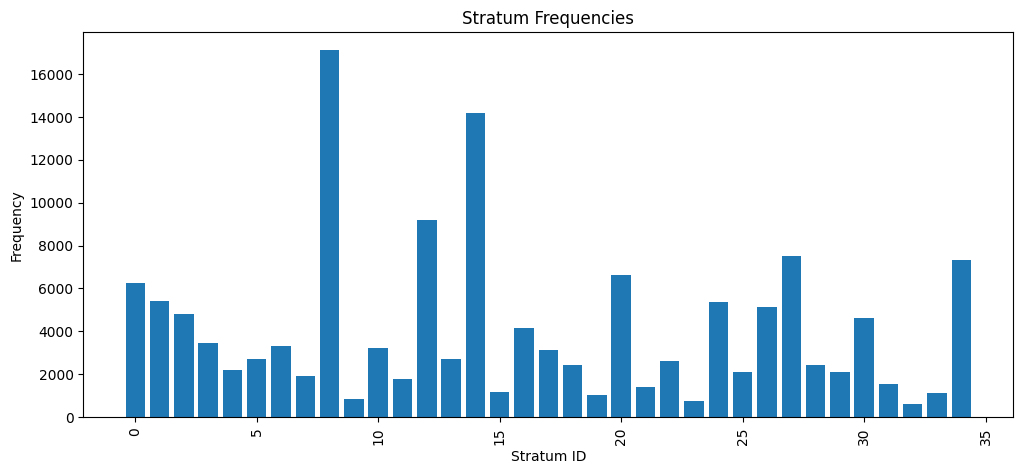

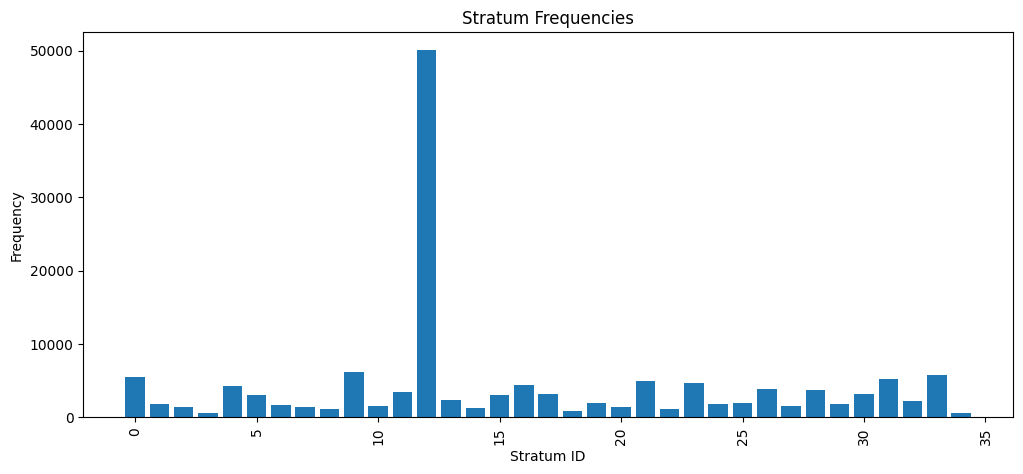

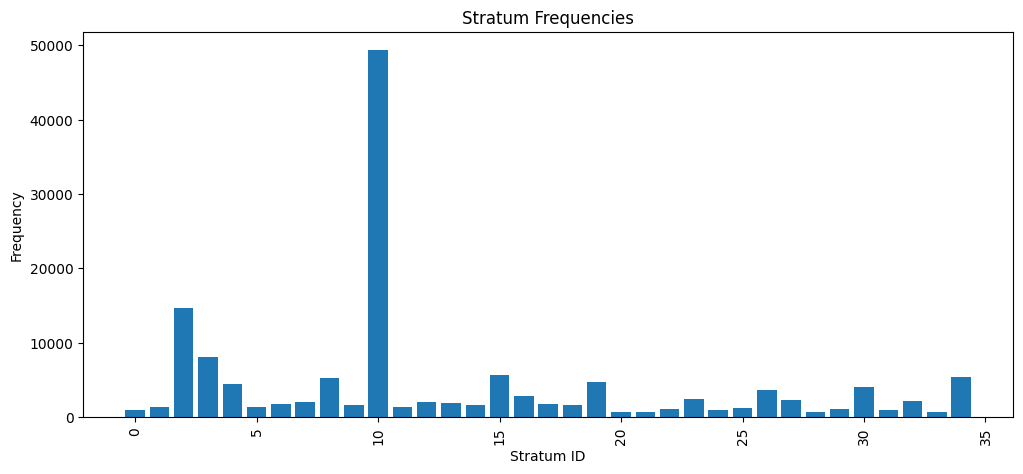

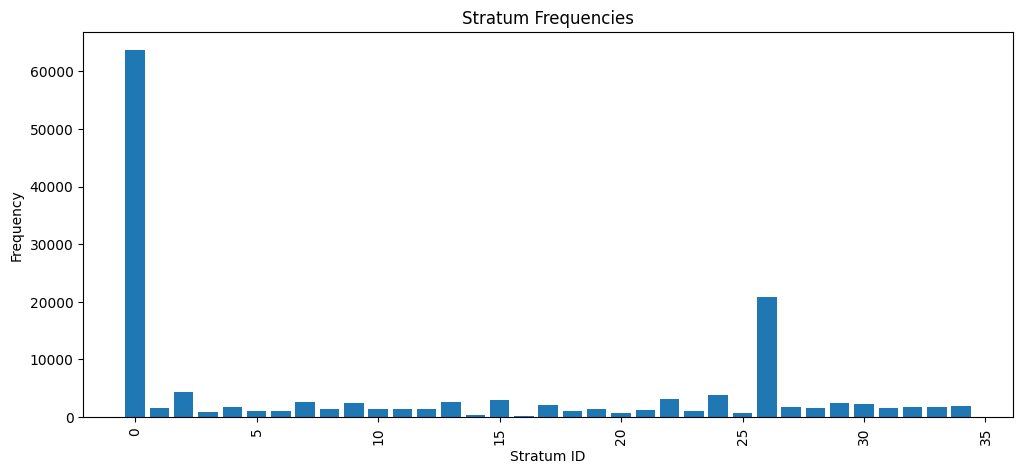

In [56]:
for name, counter in [
    ("All", all_stratum_counter),
    ("Biological Process", bp_stratum_counter),
    ("Cellular Component", cc_stratum_counter),
    ("Molecular Function", mf_stratum_counter),
]:
    plt.figure(figsize=(12, 5)) 

    plt.bar(counter.keys(), counter.values())

    plt.title(f"Stratum Frequencies")
    plt.xticks(rotation=90)
    plt.xlabel("Stratum ID")
    plt.ylabel("Frequency")

    plt.show()

Now let's loop through the sequences provided in the Fasta file and associate their GO terms, term embeddings, taxon IDs, and stratum IDs.

In [57]:
import json

from Bio import SeqIO

fasta_path = "./dataset/train/train_sequences.fasta"

mf_dataset_path = "./dataset/mf.jsonl"
bp_dataset_path = "./dataset/bp.jsonl"
cc_dataset_path = "./dataset/cc.jsonl"
all_dataset_path = "./dataset/all.jsonl"

for dataset_path, sequence_to_terms, label_embeddings, sequence_id_to_stratum in [
    (mf_dataset_path, mf_seq_to_terms, mf_label_embeddings, mf_sequence_id_to_stratum),
    (cc_dataset_path, cc_seq_to_terms, cc_label_embeddings, cc_sequence_id_to_stratum),
    (bp_dataset_path, bp_seq_to_terms, bp_label_embeddings, bp_sequence_id_to_stratum),
    (all_dataset_path, all_seq_to_terms, all_label_embeddings, all_sequence_id_to_stratum),
]:
    with open(dataset_path, "w") as dataset_file:   
        with open(fasta_path, "r") as fasta_file:
            for record in SeqIO.parse(fasta_file, "fasta"):
                sequence_id = record.id

                terms = sequence_to_terms[sequence_id]

                if len(terms) == 0:
                    continue

                sequence = str(record.seq)

                seq_length = len(sequence)

                terms_embedding = label_embeddings[sequence_id]
                taxon_id = seq_to_taxon_id[sequence_id]
                stratum_id = sequence_id_to_stratum[sequence_id]

                line = {
                    "id": sequence_id,
                    "sequence": sequence,
                    "length": seq_length,
                    "terms": terms,
                    "terms_embedding": terms_embedding.tolist(),
                    "taxon_id": str(taxon_id),
                    "stratum_id": str(stratum_id),
                }

                dataset_file.write(json.dumps(line) + "\n")

    print(f"Dataset saved to {dataset_path}")

Dataset saved to ./dataset/mf.jsonl
Dataset saved to ./dataset/cc.jsonl
Dataset saved to ./dataset/bp.jsonl
Dataset saved to ./dataset/all.jsonl


Finally, let's create stratified train and test splits based on the `stratum_id` and upload the dataset to HuggingFace Hub.

In [58]:
from datasets import load_dataset

dataset_name = "andrewdalpino/CAFA5"

for dataset_path, subset_name in [
    (all_dataset_path, "all"),
    (mf_dataset_path, "mf"),
    (bp_dataset_path, "bp"),
    (cc_dataset_path, "cc"),
]:
    hf_dataset = load_dataset("json", data_files=dataset_path)

    hf_dataset = hf_dataset.class_encode_column("stratum_id")

    hf_dataset = hf_dataset["train"].train_test_split(test_size=0.1, stratify_by_column="stratum_id", seed=42)

    hf_dataset.push_to_hub(dataset_name, subset_name)

Generating train split: 142246 examples [00:00, 559429.83 examples/s]
Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Uploading the dataset shards: 100%|██████████| 1/1 [00:04<00:00,  4.41s/it]
Generating train split: 78637 examples [00:00, 804859.71 examples/s]
Uploading the dataset shards: 100%|██████████| 1/1 [00:02<00:00,  2.45s/it]
Generating train split: 92210 examples [00:00, 546410.95 examples/s]
Uploading the dataset shards: 100%|██████████| 1/1 [00:03<00:00,  3.06s/it]
Generating train split: 92912 examples [00:00, 725401.97 examples/s]
Uploading the dataset shards: 100%|██████████| 1/1 [00:02<00:00,  2.73s/it]
